## Title

**Authors:** <br>
Björn Hahn () <br>
Domenico Ferraro (941398)<br>
Justus Raabe (940919) <br>
Lisa Sachau (941367)

#### Imported Packages

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import functions as func


#### Load Data

['./Fotos_einfach\\lion\\l1.jpeg', './Fotos_einfach\\lion\\l10.jpeg', './Fotos_einfach\\lion\\l2.jpeg', './Fotos_einfach\\lion\\l3.jpeg', './Fotos_einfach\\lion\\l4.jpeg', './Fotos_einfach\\lion\\l5.jpeg', './Fotos_einfach\\lion\\l6.jpeg', './Fotos_einfach\\lion\\l7.jpeg', './Fotos_einfach\\lion\\l8.jpeg', './Fotos_einfach\\lion\\l9.jpeg', './Fotos_einfach\\manul\\m1.jpg', './Fotos_einfach\\manul\\m10.jpg', './Fotos_einfach\\manul\\m2.jpg', './Fotos_einfach\\manul\\m3.jpg', './Fotos_einfach\\manul\\m4.jpg', './Fotos_einfach\\manul\\m5.jpg', './Fotos_einfach\\manul\\m6.jpg', './Fotos_einfach\\manul\\m7.jpg', './Fotos_einfach\\manul\\m8.jpg', './Fotos_einfach\\manul\\m9.JPG', './Fotos_einfach\\sand cat\\s1.jpg', './Fotos_einfach\\sand cat\\s10.jpg', './Fotos_einfach\\sand cat\\s2.jpg', './Fotos_einfach\\sand cat\\s3.jpg', './Fotos_einfach\\sand cat\\s4.jpg', './Fotos_einfach\\sand cat\\s5.jpg', './Fotos_einfach\\sand cat\\s6.jpg', './Fotos_einfach\\sand cat\\s7.jpg', './Fotos_einfach\\sa

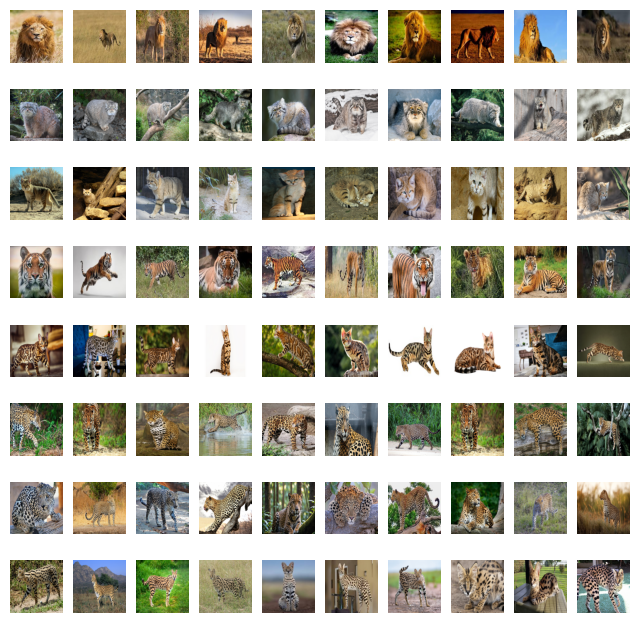

In [2]:
# Get file names
folder_e = './Fotos_einfach'
folder_h = './Fotos_schwierig'
#image_names, categories = read_image_names(filepath)
categories_e, image_names_e, labels_e = func.get_filenames_labels(folder_e)
categories_h, image_names_h, labels_h = func.get_filenames_labels(folder_h)
print(image_names_e)
print(labels_e)
print(categories_e)
print(image_names_h)
print(labels_h)
print(categories_h)
# Load images
input_shape = {
    "height": 200,
    "width": 200,
    "channels": 3
}
images_e = func.read_images(image_names_e, height=input_shape["height"], width=input_shape["width"])
images_h = func.read_images(image_names_h, height=input_shape["height"], width=input_shape["width"])
# Convert images to array
aimages_e = func.images_to_array(images_e)
aimages_h = func.images_to_array(images_h)
print(f'Shape of images array: {aimages_e.shape}')
# Plot images array
fig = plt.figure(figsize=(8, 8))
rows, columns = 8, 10

for i in range(aimages_e.shape[0]):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(aimages_e[i, ...])
    plt.axis('off')

for i in range(aimages_h.shape[0]):
    fig.add_subplot(rows, columns, aimages_e.shape[0] + i + 1)
    plt.imshow(aimages_h[i, ...])
    plt.axis('off')
    
plt.show()


#### Data Augmentation

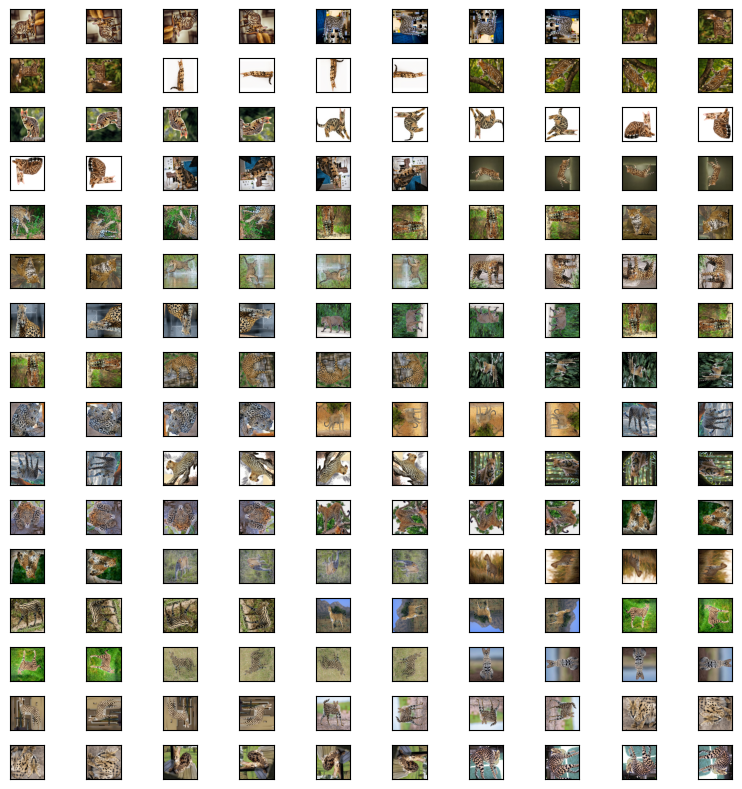

In [3]:
def augment_images(images, labels):
    aug_images = []
    aug_labels = []
    for i, row in enumerate(images):
        # Original
        aug_images.append(images[i])
        aug_labels.append(labels[i])
        
        # 90 Grad Drehung (nach rechts)
        aug_images.append(np.rot90(row, k=1))
        aug_labels.append(labels[i])
        
        # 180 Grad Drehung (nach unten)
        aug_images.append(np.rot90(row, k=2))
        aug_labels.append(labels[i])
        
        # 270 Grad Drehung (nach links)
        aug_images.append(np.rot90(row, k=3))
        aug_labels.append(labels[i])
    
    return aug_images, aug_labels

# Anwenden der Augmentierung auf einfache Bilder
a_images_e, a_labels_e = augment_images(aimages_e, labels_e)
aug_images_e = func.images_to_array(a_images_e)
aug_labels_e = func.images_to_array(a_labels_e)

# Anwenden der Augmentierung auf schwierige Bilder
a_images_h, a_labels_h = augment_images(aimages_h, labels_h)
aug_images_h = func.images_to_array(a_images_h)
aug_labels_h = func.images_to_array(a_labels_h)

total_images = aug_images_h.shape[0]
columns = 10
rows = int(np.ceil(total_images / columns))  # Dynamische Anzahl der Zeilen

fig = plt.figure(figsize=(8, 8))
for i in range(total_images):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.imshow(aug_images_h[i, ...])
    ax.set_xticks([])  # Entfernt x-Achsen-Ticks
    ax.set_yticks([])  # Entfernt y-Achsen-Ticks
    ax.grid(False)     # Deaktiviert das Raster innerhalb der Subplots

plt.tight_layout()
plt.show()



Encode Labels

In [4]:
y_e = func.ownOneHotEncoder(aug_labels_e, categories_e)
y_h = func.ownOneHotEncoder(aug_labels_h, categories_h)

Training and Test-Split with K-Fold (vielleicht K-Fold auch später, unsicher bei Reihenfolge tbh)

In [ ]:
data_e = aug_images_e
data_h = aug_images_h
k = 6
image_folds_e, y_folds_e = func.stratified_k_fold(data_e, y_e, k)
image_folds_h, y_folds_h = func.stratified_k_fold(data_h, y_h, k)
fig = plt.figure(figsize=(2, 1))

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0

<Figure size 200x100 with 0 Axes>

#### Build Model

easy difficulty

In [ ]:
epoch = 25
eval_accuracy_e = []
accuracy_e = []
z = list(range(k)) 
for i in range(k):
    test_fold_index = z[k-1] if k % 2 == 0 else z[k-2]
    if test_fold_index == i:
        continue
    fold_x_train = np.concatenate([image_folds_e[j] for j in range(k) if j != i and j != test_fold_index], axis=0)
    fold_y_train = np.concatenate([y_folds_e[j] for j in range(k) if j != i and j != test_fold_index], axis=0)
    fold_x_val = image_folds_e[i]
    fold_y_val = y_folds_e[i]
    fold_x_test = image_folds_e[test_fold_index]
    fold_y_test = y_folds_e[test_fold_index]
    model, model_accuracy = func.build_model(epoch, fold_x_train, fold_y_train, fold_x_val, fold_y_val, fold_x_test, fold_y_test, input_shape)
    eval_accuracy_e.append(model_accuracy)
    accuracy_e.append(max(model.history['accuracy']))
    z = z[:-1] 
    z = [test_fold_index] + z
    
print(eval_accuracy_e)
print(accuracy_e)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2049 - loss: 7772.2241 - val_accuracy: 0.2593 - val_loss: 209.6918
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3508 - loss: 296.7417 - val_accuracy: 0.2593 - val_loss: 5.1154
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3629 - loss: 20.0900 - val_accuracy: 0.3333 - val_loss: 1.6103
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4115 - loss: 12.8677 - val_accuracy: 0.4444 - val_loss: 1.3579
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4497 - loss: 5.3419 - val_accuracy: 0.4444 - val_loss: 1.3797
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5655 - loss: 2.2314 - val_accuracy: 0.4444 - val_loss: 1.3323
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5730 - loss: 1.6219 - val_accuracy: 0.2963 - val_loss: 1.3781
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8023 - loss: 0.6052 - val_accuracy: 0.3333 - val_loss: 1.3507
Epoch 

Plotting of Accuracy and Accuracy of the model

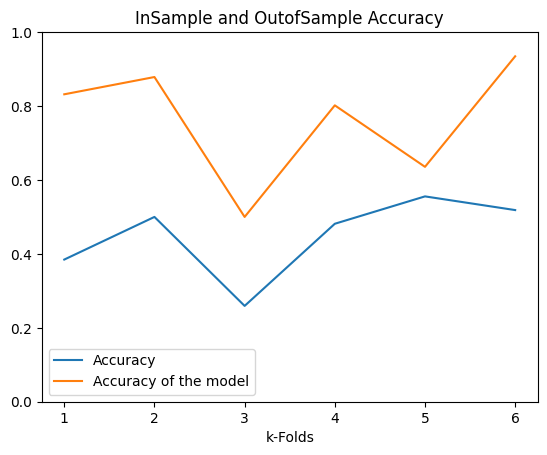

In [8]:
# noch zu überarbeiten
tick_labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.plot(range(1, k+1), eval_accuracy_e)
plt.plot(range(1, k+1), accuracy_e)
plt.title('InSample and OutofSample Accuracy')
plt.xlabel('k-Folds')
plt.yticks(tick_labels)
plt.gca().legend(('Accuracy', 'Accuracy of the model'))
plt.show()

hard difficulty

In [8]:
epoch = 25
eval_accuracy_h = []
accuracy_h = []
for i in range(k):
    fold_x_train = np.concatenate([image_folds_h[j] for j in range(k) if j != i], axis=0)
    fold_y_train = np.concatenate([y_folds_h[j] for j in range(k) if j != i], axis=0)
    fold_x_val = image_folds_h[i]
    fold_y_val = y_folds_h[i]
    model, model_accuracy = func.build_model(epoch, fold_x_train, fold_y_train, fold_x_val, fold_y_val, input_shape)
    eval_accuracy_h.append(model_accuracy)
    accuracy_h.append(max(model.history['accuracy']))
print(eval_accuracy_h)
print(accuracy_h)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3567 - loss: 6137.3325 - val_accuracy: 0.2500 - val_loss: 471.4850
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2138 - loss: 862.7879 - val_accuracy: 0.3500 - val_loss: 4.2431
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2906 - loss: 15.2593 - val_accuracy: 0.3000 - val_loss: 1.4055
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4494 - loss: 1.8288 - val_accuracy: 0.3500 - val_loss: 1.3666
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5419 - loss: 1.2175 - val_accuracy: 0.3750 - val_loss: 1.3529
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6431 - loss: 0.9769 - val_accuracy: 0.4500 - val_loss: 1.3585
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6494 - loss: 0.9590 - val_accuracy: 0.3250 - val_loss: 1.3721
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7504 - loss: 0.6444 - val_accuracy: 0.3000 - val_loss: 1.3662
Epoch 9/

Plotting of Accuracy and Loss for hard difficulty

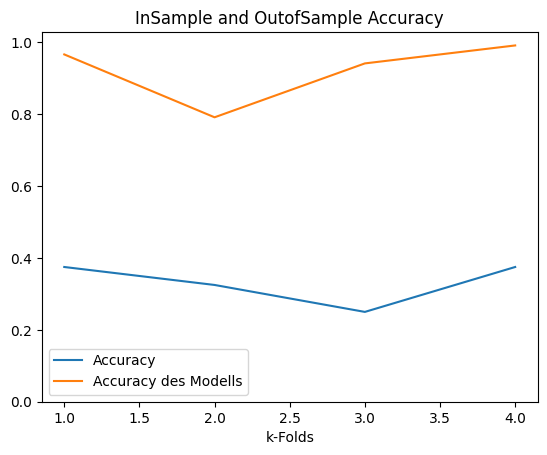

In [9]:
#auch noch zu überarbeiten
tick_labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.plot(range(1, k+1), eval_accuracy_h)
plt.plot(range(1, k+1), accuracy_h)
plt.title('InSample and OutofSample Accuracy')
plt.xlabel('k-Folds')
plt.yticks(tick_labels)
plt.gca().legend(('Accuracy', 'Accuracy des Modells'))
plt.show()

Prediction

In [ ]:
#prediction here